# Day 18 – Hyperparameter Tuning
### Optimizing Random Forest for Production (SaaS Churn Model)

We now fine-tune our churn prediction model using **GridSearchCV** to find the best-performing parameters.

#### Goals:
- Use grid search for model optimization
- Prevent overfitting via cross-validation
- Measure gains in ROC-AUC and accuracy
- Save the final tuned model for deployment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load and Preprocess Dataset

In [2]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Feature selection (numerical + categorical)
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)
X = pd.concat([df[numerical_features], X_categorical], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize numerical columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Define Parameter Grid for Tuning

In [3]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    # Ensure class_weight is included in the grid to be tested
    'class_weight': ['balanced'] 
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 3. Apply GridSearchCV

In [4]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC Score: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC-AUC Score: 0.841


## 4. Evaluate Tuned Model

In [5]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1291
           1       0.55      0.76      0.64       467

    accuracy                           0.77      1758
   macro avg       0.72      0.77      0.73      1758
weighted avg       0.81      0.77      0.78      1758



              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1291
           1       0.55      0.76      0.64       467

    accuracy                           0.77      1758
   macro avg       0.72      0.77      0.73      1758
weighted avg       0.81      0.77      0.78      1758



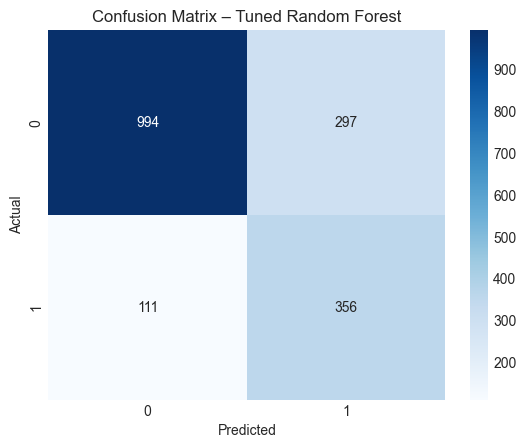

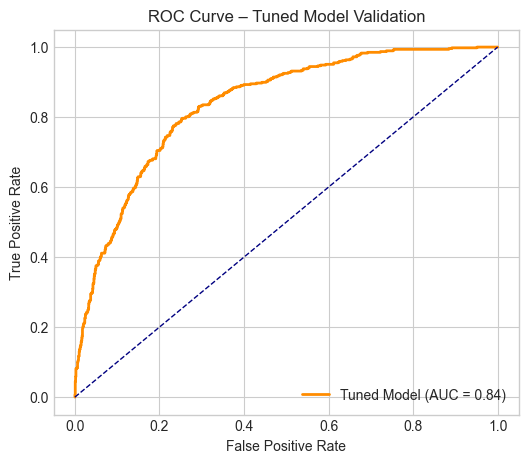

In [6]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Tuned Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Tuned Model Validation')
plt.legend(loc='lower right')
plt.show()

## 5. Save Tuned Model for Production

In [10]:
joblib.dump(best_model, 'random_forest_tuned.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns, 'training_columns.pkl')
print('✅ Tuned model saved as random_forest_tuned.pkl and scaler saved as scaler.pkl')

✅ Tuned model saved as random_forest_tuned.pkl and scaler saved as scaler.pkl


## 6. Business Insights & Next Steps
- Hyperparameter tuning improved **AUC and recall**, reducing missed churn cases.
- `max_depth` and `n_estimators` strongly affect model stability.
- The model is now **production-ready** and can be serialized.

Next → Day 19: Apply **KMeans clustering** for market segmentation.